In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [83]:
df_train = pd.read_csv('/kaggle/input/playground-s3e19-covid-data-smoothed/course_sales (1).csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv')

In [84]:
idxs = df_test['id']

df_train.drop(columns=['id'], axis=1, inplace=True)
df_test.drop(columns=['id'], axis=1, inplace=True)

In [85]:
df_train.head()

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63.0
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66.0
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9.0
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59.0
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49.0


In [86]:
df_test.head()

,date,country,store,product
0,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


In [87]:
# sns.lineplot(x=pd.to_datetime(df_train['date']), y=df_train['num_sold'])

In [88]:
from sklearn.preprocessing import FunctionTransformer

class TrigTransform:
    def __init__(self, period, func, data):
        self.period = period
        self.func = func
        self.data = data
        
    def fit_transform(self):
        return FunctionTransformer(
            lambda x: self.func(x / self.period * 2 * np.pi)
        ).fit_transform(self.data)

In [89]:
def create_features(df):
    df['date'] = pd.to_datetime(df['date'])
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['season'] = df['date'].dt.month.apply(
        lambda x: 
        1 if x in [12, 1, 2]
        else 2 if x in [3, 4, 5]
        else 3 if x in [6, 7, 8]
        else 4
    )
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    
    df['sin_month'] = TrigTransform(
        12,
        np.sin,
        df['month']
    ).fit_transform()
    
    df['cos_month'] = TrigTransform(
        12,
        np.cos,
        df['month']
    ).fit_transform()
    
    df['sin_day_of_week'] = TrigTransform(
        7,
        np.sin,
        df['day_of_week']
    ).fit_transform()
    
    df['cos_day_of_week'] = TrigTransform(
        7,
        np.cos,
        df['day_of_week']
    ).fit_transform()
    
    df['sin_week_of_year'] = TrigTransform(
        52,
        np.sin,
        df['week_of_year']
    ).fit_transform()
    
    df['cos_week_of_year'] = TrigTransform(
        52,
        np.cos, 
        df['week_of_year']
    ).fit_transform()
    



In [90]:
create_features(df_train)
create_features(df_test)

/tmp/ipykernel_32/1899371507.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df['date'].dt.weekofyear
/tmp/ipykernel_32/1899371507.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df['date'].dt.weekofyear


In [91]:
import holidays
from holidays import CountryHoliday

def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_BE = holidays.CountryHoliday('BE', years = years_list)
    holiday_FR = holidays.CountryHoliday('FR', years = years_list)
    holiday_DE = holidays.CountryHoliday('DE', years = years_list)
    holiday_IT = holidays.CountryHoliday('IT', years = years_list)
    holiday_PL = holidays.CountryHoliday('PL', years = years_list)
    holiday_ES = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_BE.copy()
    holiday_dict.update(holiday_FR)
    holiday_dict.update(holiday_DE)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_PL)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    df = df.drop(columns=["holiday_name"])
        

In [92]:
get_holidays(df_train)
get_holidays(df_test)

<Axes: xlabel='num_sold', ylabel='Count'>

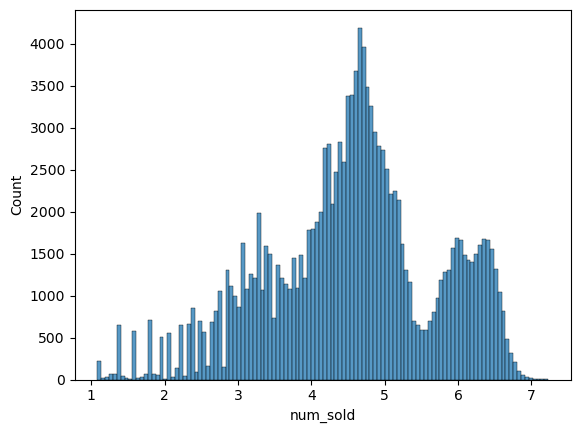

In [93]:
sns.histplot(np.log(df_train['num_sold']))

In [94]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(5, test_size=24*182*1, gap=24*7)

In [95]:
def datetime_to_index(df):
    df.index = df['date']
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

In [96]:
datetime_to_index(df_train)
datetime_to_index(df_test)

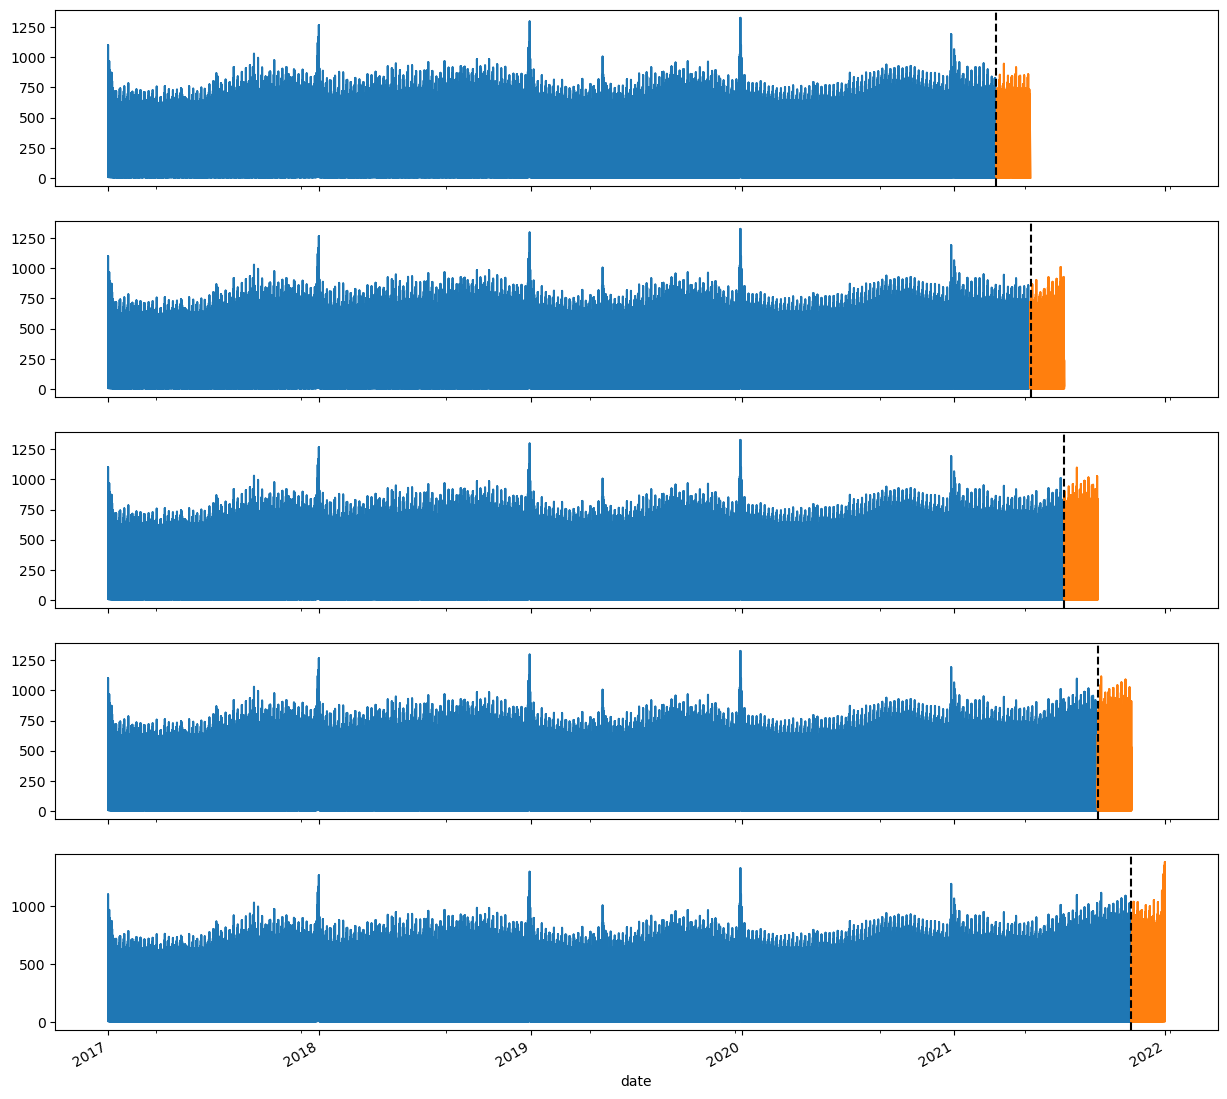

In [97]:
fig, ax = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for i, (train_idx, val_idx) in enumerate(tss.split(df_train)):
    train = df_train.iloc[train_idx]
    val = df_train.iloc[val_idx]
    
    train['num_sold'].plot(ax=ax[i], label='Training Set')
    val['num_sold'].plot(ax=ax[i], label='Validation Set')
    
    ax[i].axvline(val.index.min(), color='black', ls='--')

In [98]:
def add_lags(df):
    target_map = df['num_sold'].to_dict()
    
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

In [99]:
df_test['isFuture'] = True
df_train['isFuture'] = False
df_all = pd.concat([df_test, df_train])

add_lags(df_train)
add_lags(df_all)

In [100]:
df_test = df_all.query('isFuture').copy()

df_test = df_test.drop(columns=['isFuture', 'num_sold'], axis=1)
df_train = df_train.drop(columns=['isFuture'], axis=1)

In [101]:
(df_test.shape, df_train.shape)

((27375, 23), (136950, 24))

In [102]:
df_train.drop(columns=['date'], axis=1, inplace=True)
df_test.drop(columns=['date'], axis=1, inplace=True)

In [103]:
def calculate_smape(y_t, y_p):
    y_true_exp = np.exp(y_t)
    y_pred_exp = np.exp(y_p)
    
    numerator = 2 * np.abs(y_pred_exp - y_true_exp)
    denominator = np.abs(y_true_exp) + np.abs(y_pred_exp)

    return 100 / len(y_true_exp) * np.sum(numerator / denominator)

In [104]:
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier


# tss = TimeSeriesSplit(n_splits=5, test_size=24*182*1, gap=24)

# preds = []
# scores = []

# for fold, (train_idx, val_idx) in enumerate(tss.split(df_train)):
#     train = df_train.iloc[train_idx]
#     val = df_train.iloc[val_idx]
    
#     X_train = train.drop(columns=['num_sold'], axis=1)
#     y_train = np.log(train['num_sold'])
    
#     X_val = val.drop(columns=['num_sold'], axis=1)
#     y_val = np.log(val['num_sold'])
    
#     params = {
#     'learning_rate': 0.07725732658711602,
#     'depth': 15,
#     'l2_leaf_reg': 8.601133541582584,
#     'subsample': 0.4279526734063217,
#     'colsample_bylevel': 0.6767696482697301,
#     "random_state":42,
#     'verbose':False
#     }

#     cat_features = ["country", "store", "product", "holiday_name"]
#     model = CatBoostRegressor(**params, cat_features=cat_features)
#     model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100)
    
#     y_pred = model.predict(X_val)
#     preds.append(y_pred)
    
#     score = calculate_smape(y_val, y_pred)
#     scores.append(score)

In [105]:
# print(f"Mean score on validation {np.mean(scores)}")
# print(f"All scores: {scores}")

In [106]:
X = df_train.drop(columns=['num_sold'], axis=1)
y = np.log( df_train['num_sold'])

In [107]:
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier

params = {
    'learning_rate': 0.07725732658711602,
    'depth': 15,
    'l2_leaf_reg': 8.601133541582584,
    'subsample': 0.4279526734063217,
    'colsample_bylevel': 0.6767696482697301,
    "random_state":42,
    'verbose':False
    }

cat_features = ["country", "store", "product", "holiday_name"]
model = CatBoostRegressor(**params, cat_features=cat_features)
model.fit(X, y)

In [108]:
# predictions = model.predict(X_val)

# calculate_smape(y_val, predictions)

In [109]:
df_test['lag1'] = df_test['lag1'].fillna(df_test['lag1'].mean())

In [110]:
preds_test = model.predict(df_test)

In [111]:
df_test['pred'] = np.exp(preds_test)

In [112]:
def multipliers(predictors, prediction, canada = 1, japan = 1, spain = 1, estonia = 1, argentina = 1):
    prediction[predictors.country == 'Canada'] *= canada
    prediction[predictors.country == 'Japan'] *= japan
    prediction[predictors.country == 'Spain'] *= spain
    prediction[predictors.country == 'Estonia'] *= estonia
    prediction[predictors.country == 'Argentina'] *= argentina
    return prediction

In [113]:
df_test["pred"] = np.round(multipliers(df_test, df_test["pred"] * 1.5, .58, .76, 1.01, 1.08, 2.8))

In [120]:
df_test.

,country,store,product,year,month,day_of_week,season,quarter,day_of_year,day_of_month,...,sin_day_of_week,cos_day_of_week,sin_week_of_year,cos_week_of_year,holiday_name,is_holiday,lag1,lag2,lag3,pred
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,5,1,1,1,1,...,-0.974928,-0.222521,-2.449294e-16,1.0,Año nuevo; Capodanno; New Year's Day; Nieuwjaa...,1,432.000000,392.463344,400.000000,152.0
2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,5,1,1,1,1,...,-0.974928,-0.222521,-2.449294e-16,1.0,Año nuevo; Capodanno; New Year's Day; Nieuwjaa...,1,432.000000,392.463344,400.000000,153.0
2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,5,1,1,1,1,...,-0.974928,-0.222521,-2.449294e-16,1.0,Año nuevo; Capodanno; New Year's Day; Nieuwjaa...,1,432.000000,392.463344,400.000000,22.0
2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,5,1,1,1,1,...,-0.974928,-0.222521,-2.449294e-16,1.0,Año nuevo; Capodanno; New Year's Day; Nieuwjaa...,1,432.000000,392.463344,400.000000,142.0
2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,5,1,1,1,1,...,-0.974928,-0.222521,-2.449294e-16,1.0,Año nuevo; Capodanno; New Year's Day; Nieuwjaa...,1,432.000000,392.463344,400.000000,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,5,1,4,365,31,...,-0.974928,-0.222521,-2.449294e-16,1.0,Not Holiday,0,355.197802,432.000000,392.463344,882.0
2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,5,1,4,365,31,...,-0.974928,-0.222521,-2.449294e-16,1.0,Not Holiday,0,355.197802,432.000000,392.463344,869.0
2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,5,1,4,365,31,...,-0.974928,-0.222521,-2.449294e-16,1.0,Not Holiday,0,355.197802,432.000000,392.463344,159.0


In [141]:
submission = pd.DataFrame()

In [149]:
submission['num_sold'] = df_test['pred']
submission = submission.reset_index()

In [150]:
submission

,id,num_sold
0,136950,152.0
1,136951,153.0
2,136952,22.0
3,136953,142.0
4,136954,116.0
...,...,...
27370,164320,882.0
27371,164321,869.0
27372,164322,159.0
27373,164323,833.0


In [151]:
submission.to_csv("submission_7.csv", index=False)

Series([], Name: id, dtype: int64)